In [41]:
import h5py
import os
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [42]:
def modulo_degrees_between_m180_p180(angle_degrees):
    '''
    Inputs:
        angle_degrees: np.array

    Convert arbitrary angle in degrees (any real number) to that between -180
    and +180 degrees.
    '''
    angle_new = angle_degrees % 360.0
    angle_new[angle_new > 180.0] -= 360.0

    return angle_new


In [43]:
def is_between_lo_hi(x, lo, hi):
    '''
    Inputs:
        x: float or nd np.array
        lo: float, lower bound
        hi: float, upper bound
    Returns:
        out: bool nd np.array of same shape as x indicating whether each element is
             between lo and hi
    '''
    out = (x >= lo) * (x < hi)
    return out


In [44]:
def find_contiguous_trues(x):
    '''
    Input:
        x: bool 1d np.array

    Identifies the start locations and lengths of all contiguous chunks of
    True values, separated by one or more False values.
    '''
    starts = []
    lengths = []
    acc_len = 0

    if len(x) == 0:
        return []

    if x[0] == True:
        starts.append(0)
        acc_len += 1

    for i in range(1,len(x)):
        if x[i] == True:
            acc_len += 1
            if x[i-1] == False:
                starts.append(i)
        else:
            if acc_len > 0:
                lengths.append(acc_len)
            acc_len = 0

    # If last value was True, add acc_len to lengths
    if acc_len > 0:
        lengths.append(acc_len)

    assert len(starts) == len(lengths)

    out = list(zip(starts, lengths))

    return out



In [88]:
def load_fictrac(directory, file='fictrac.dat'):
    """ Loads fictrac data from .dat file that fictrac outputs.
    To-do: change units based on diameter of ball etc.
    For speed sanity check, instead remove bad frames so we don't have to throw out whole trial.
    Parameters
    ----------
    directory: string of full path to file
    file: string of file name
    Returns
    -------
    fictrac_data: pandas dataframe of all parameters saved by fictrac """

    for item in os.listdir(directory):
      if '.dat' in item:
        file = item

    with open(os.path.join(directory, file),'r') as f:
        df = pd.DataFrame(l.rstrip().split() for l in f)

        # Name columns
        df = df.rename(index=str, columns={0: 'frameCounter',
                                       1: 'dRotCamX',
                                       2: 'dRotCamY',
                                       3: 'dRotCamZ',
                                       4: 'dRotScore',
                                       5: 'dRotLabX',
                                       6: 'dRotLabY',
                                       7: 'dRotLabZ',
                                       8: 'AbsRotCamX',
                                       9: 'AbsRotCamY',
                                       10: 'AbsRotCamZ',
                                       11: 'AbsRotLabX',
                                       12: 'AbsRotLabY',
                                       13: 'AbsRotLabZ',
                                       14: 'positionX',
                                       15: 'positionY',
                                       16: 'heading',
                                       17: 'runningDir',
                                       18: 'speed',
                                       19: 'integratedX',
                                       20: 'integratedY',
                                       21: 'timeStamp',
                                       22: 'sequence'})

        # Remove commas
        for column in df.columns.values[:-1]:
            df[column] = [float(x[:-1]) for x in df[column]]

        fictrac_data = df
                
    # sanity check for extremely high speed (fictrac failure)
    speed = np.asarray(fictrac_data['speed'])
    max_speed = np.max(speed)
    if max_speed > 10:
        raise Exception('Fictrac ball tracking failed (reporting impossibly high speed).')
    return fictrac_data

In [ ]:
### convert units for common cases ###
sphere_radius = 4.5e-3 # in m
if behavior in ['dRotLabY']:
    ''' starts with units of rad/frame
    * sphere_radius(m); now in m/frame
    * fps; now in m/sec
    * 1000; now in mm/sec '''

    fictrac_interp = fictrac_interp * sphere_radius * fps * 1000 # now in mm/sec

In [136]:
def analyze_fix_stationary(hdf_path, front_region=[-15,15]):
    #h5f_path = "/Users/yandanwang/Desktop/fix_stationary/20220410_201217.h5"

    ## Import data from h5 file
    h5f = h5py.File(hdf_path, 'r')

    trials = h5f['trials']
    iti = h5f.attrs['iti'] if 'iti' in h5f.attrs.keys() else 2 # if iti was not saved, assume 2 seconds
    stim_duration = h5f.attrs['fix_duration']

    ###
    directory = '/Users/yandanwang/Desktop/data/fix_stationary/20220413_140128'
    fictrac = load_fictrac(directory, 'fictrac-20220413_140129.dat')
    x_original = np.asarray(fictrac['timeStamp'])/1000
    fictrac_to_interp = np.asarray(fictrac['dRotLabY'])
    sphere_radius = 4.5e-3
    fps = 300
    fictrac_to_interp = fictrac_to_interp * sphere_radius * fps * 1000 # now in mm/sec
    fictrac_interp_temp = interp1d(x_original, fictrac_to_interp, bounds_error = False)
    
    ## for each trial, get...
    acc_fixation_success = []
    acc_fixation_durations = []
    acc_max_fixation_duration = []
    acc_ini_r_v = []
    acc_theta_bar_0 = []
    acc_mean_bar_position = []
    for tkey in trials.keys():
        #tkey='000'
        trial = trials[tkey]
        
        ### extract forward velocity
        trial_timestamps = list(trial['ft_timestamps'])
        trial_fwd_v = fictrac_interp_temp(trial_timestamps)
        trial_fwd_v = gaussian_filter1d(trial_fwd_v, sigma=10)
        ##########################

        ### 0. Pull out timestamps and theta from trial object
        theta_rad = trial['ft_theta'][()] # raw theta in radians from Fictrac
        theta_rad -= theta_rad[0] # theta in radians relative to the beginning of trial
        theta_deg = np.rad2deg(theta_rad)
        ts = trial['ft_timestamps'] # timestamps in seconds since epoch
        ts -= (ts[0] + iti) # timestamps in seconds relative to the first timestamp of trial
        dt = np.mean(np.diff(ts)) # average width of a time step

        theta_bar_0 = trial.attrs['start_theta'] #degrees
        theta_bar = theta_bar_0 - theta_deg # bar position
        acc_theta_bar_0.append(theta_bar_0)
        
        stim_period_mask = is_between_lo_hi(ts, 0, stim_duration)
        ts_stim = ts[stim_period_mask]
        theta_deg_stim = theta_deg[stim_period_mask]
        theta_bar_stim = theta_bar[stim_period_mask]
        
        ### Angular velocity
        r_v = np.diff(theta_deg)/np.diff(ts)
        ts_v = ts[:-1] # timestamp for velocity removes the last timepoint
        
        # Remove noise peaks in the velocity trace
        noise_peak_locations = np.abs(r_v) > 1000 #fly can't turn faster than 1000 degs/sec
        r_v[noise_peak_locations] = interp1d(r_v[~noise_peak_locations], ts_v[~noise_peak_locations])(ts_v[noise_peak_locations])
        
        # Apply 1d Gaussian filter smoothing to the velocity trace
        sigma_in_sec = 0.1
        sigma = int(sigma_in_sec/dt)
        r_v = gaussian_filter1d(r_v, sigma)
        
        ### the relationship between the initial theta and the initial angular velocity
        starting_index = int(2/dt)
        ending_index = int(3/dt) 
        ini_r_v = np.mean(r_v[starting_index: ending_index])
        acc_ini_r_v.append(ini_r_v)
    
        ### the mean position of the bar for each trial
        mean_bar_position = np.mean(theta_bar)
        acc_mean_bar_position.append(mean_bar_position)
    
        ### 1. amount of time spent in the front region (param)
        theta_wrapped = modulo_degrees_between_m180_p180(theta_bar_stim)
        in_front_region = is_between_lo_hi(theta_wrapped, \
                                           lo=front_region[0], hi=front_region[1])
        duration_in_front_region = np.sum(in_front_region) * dt # in seconds
        proportion_in_front_region = np.sum(in_front_region) / len(in_front_region)

        print(f'Trial {tkey}: {duration_in_front_region:.2f}s ({proportion_in_front_region * 100:.1f}%) in front')

        ### 2. Quantify successful fixation (defined as >2s of staying within front region)
        true_chunks = find_contiguous_trues(in_front_region)
        fixation_durations = np.asarray([x[1]*dt for x in true_chunks])

        fixation_success = np.any(fixation_durations >= 2)
        if np.sum(fixation_durations) == 0:
            max_fixation_duration = 0
        else:
            max_fixation_duration = np.max(fixation_durations)
        # max_fixation_duration = np.max(fixation_durations)
        acc_fixation_success.append(fixation_success)
        acc_fixation_durations.append(fixation_durations)
        acc_max_fixation_duration.append(max_fixation_duration)

        print(f'Trial {tkey}: Fixation success: {fixation_success}')
        print(f'Trial {tkey}: Maximum fixation duration: {max_fixation_duration:.2f}s')
        
        #plt.figure()
        #plt.plot(ts, modulo_degrees_between_m180_p180(theta_bar))
        fig,ax = plt.subplots(5,1, figsize=(10,6))
        ax[0].plot(ts, np.sin(np.deg2rad(theta_bar)))
        ax[0].set_ylim([-1,1])
        ax[0].set_ylabel(r"sin($\theta_{bar}$)")
        ax[0].grid(True)
        ax[1].plot(ts, modulo_degrees_between_m180_p180(theta_bar))
        ax[1].set_ylim([-180,180])
        ax[1].set_ylabel(r"$\theta_{bar}$ [$\circ$]")
        ax[1].set_xlabel('Time [s]')        
        ax[1].grid(True)
        ax[2].plot(ts_v, r_v)
        # ax[2].set_ylim([-500,500])
        ax[2].set_ylabel(r"$d\theta_{bar}/dt$ [$\circ$/s]")
        ax[2].set_xlabel('Time [s]')        
        ax[2].grid(True)
        
        ax[3].plot(ts, trial_fwd_v)
        ax[4].plot(trial_fwd_v[:-1],r_v)
        plt.show()
        
    h5f.close()
    
    
    ### Analyze relationship between initial bar theta and initial fly theta velocity
    
    acc_theta_bar_0 = np.asarray(acc_theta_bar_0)
    acc_ini_r_v = np.asarray(acc_ini_r_v)
    
    # Scatter plot
    plt.figure()
    plt.scatter(acc_theta_bar_0, acc_ini_r_v)
    plt.xlabel(r'Initial $\theta_{bar}$ [$\circ$]')
    plt.ylabel(r'Initial $d\theta_{bar}/dt$ [$\circ$/s]')
    
    # Fit linear regression
    reg = LinearRegression().fit(acc_theta_bar_0[:,None], acc_ini_r_v)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    score = reg.score(acc_theta_bar_0[:,None], acc_ini_r_v)
    reg_line_x = np.asarray([-75, 75])
    plt.plot(reg_line_x, reg_line_x*slope+intercept)
    plt.title(f'Score: {score:.2f}; y={slope:.2f}x + {intercept:.2f}')
    
    return acc_fixation_success, acc_fixation_durations, acc_max_fixation_duration, acc_mean_bar_position



In [113]:
hdf_path = "/Users/yandanwang/Desktop/data/fix_stationary/20220413_140128.h5"
h5f = h5py.File(hdf_path, 'r')
trial_timestamps = list(h5f['trials']['012']['ft_timestamps'])#.keys()


In [121]:
x_original = np.asarray(fictrac['timeStamp'])/1000
fictrac_to_interp = np.asarray(fictrac['dRotLabY'])
                        
fictrac_interp_temp = interp1d(x_original, fictrac_to_interp, bounds_error = False)
                        
trial_fwd_v = fictrac_interp_temp(trial_timestamps)

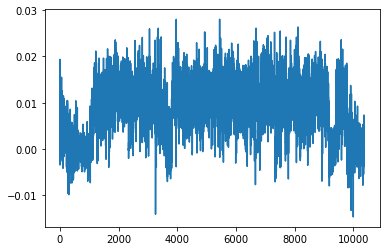

In [123]:
plt.plot(trial_fwd_v)

In [119]:
trial_timestamps[0]

1649884083.3846002

In [99]:
np.diff(a)

array([0.00329971, 0.00330019, 0.00329995, ..., 0.00329995, 0.00329995,
       0.00320005])

In [107]:
1/0.00329971

303.056935306436

In [98]:
a[1]-a[0]

0.003299713134765625

In [105]:
10371/33

314.27272727272725

In [104]:
10371/0.003299713134765625

3143000.4901734106

In [111]:
import pandas as pd
from scipy.interpolate import interp1d

In [91]:
directory = '/Users/yandanwang/Desktop/data/fix_stationary/20220413_140128'
fictrac = load_fictrac(directory, 'fictrac-20220413_140129.dat')

In [110]:
fictrac['timeStamp'][0]

0         1.649884e+12
1         1.649884e+12
2         1.649884e+12
3         1.649884e+12
4         1.649884e+12
              ...     
393715    1.649885e+12
393716    1.649885e+12
393717    1.649885e+12
393718    1.649885e+12
393719    1.649885e+12
Name: timeStamp, Length: 393720, dtype: float64

In [96]:
fictrac['timeStamp'][-1]

1649884981566.9

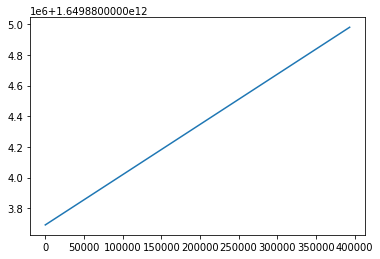

In [94]:
plt.plot(np.asarray(fictrac['timeStamp']))

(array([1., 2., 1., 3., 9., 5., 5., 8., 1., 5.]),
 array([-296.91660898, -244.99978941, -193.08296984, -141.16615027,
         -89.24933071,  -37.33251114,   14.58430843,   66.501128  ,
         118.41794756,  170.33476713,  222.2515867 ]),
 <BarContainer object of 10 artists>)

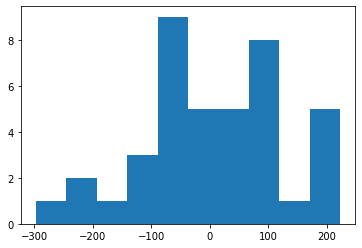

In [158]:
plt.hist(np.asarray(acc_mean_bar_position),bins=10)

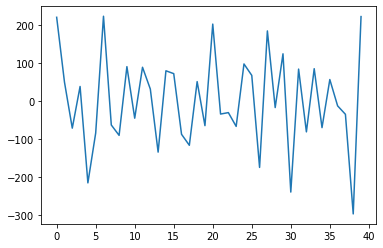

In [142]:
plt.plot(acc_mean_bar_position)

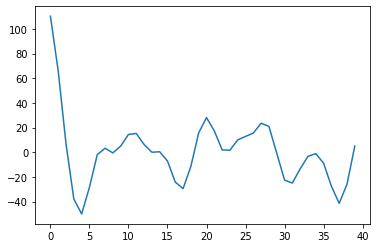

In [154]:
smoothed_acc_mean_bar_position = gaussian_filter1d(acc_mean_bar_position,sigma =1.5)
#smoothed_acc_mean_bar_position
plt.plot(smoothed_acc_mean_bar_position)

Trial 000: 0.00s (0.0%) in front
Trial 000: Fixation success: False
Trial 000: Maximum fixation duration: 0.00s


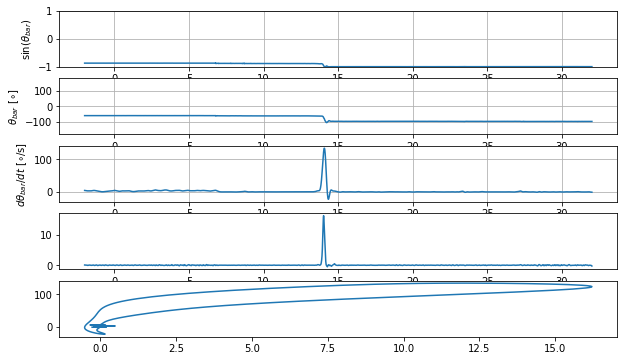

Trial 001: 0.00s (0.0%) in front
Trial 001: Fixation success: False
Trial 001: Maximum fixation duration: 0.00s


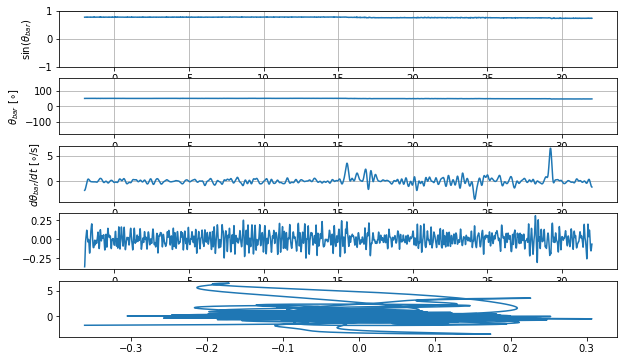

Trial 002: 0.00s (0.0%) in front
Trial 002: Fixation success: False
Trial 002: Maximum fixation duration: 0.00s


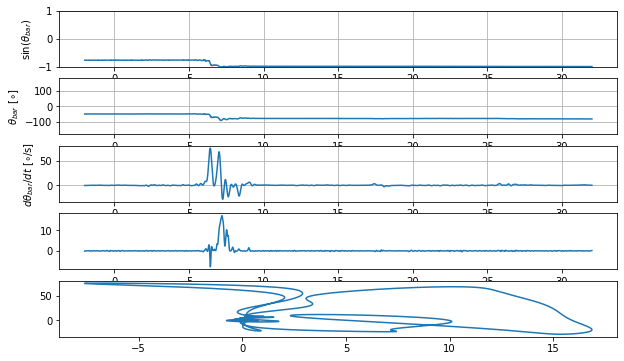

Trial 003: 0.34s (1.1%) in front
Trial 003: Fixation success: False
Trial 003: Maximum fixation duration: 0.34s


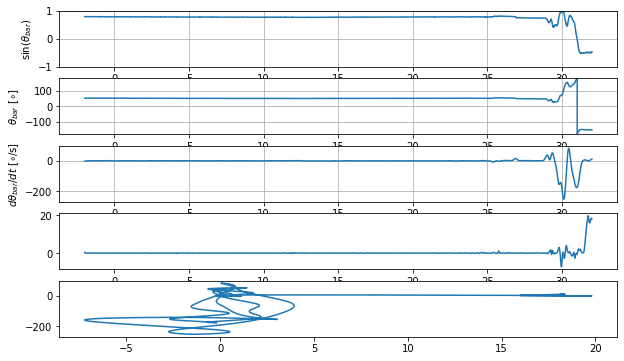

Trial 004: 0.00s (0.0%) in front
Trial 004: Fixation success: False
Trial 004: Maximum fixation duration: 0.00s


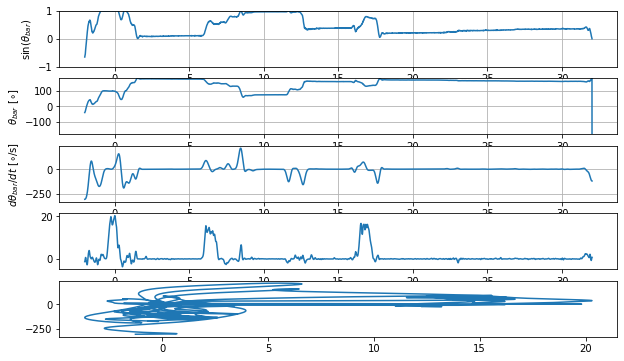

Trial 005: 4.50s (15.0%) in front
Trial 005: Fixation success: True
Trial 005: Maximum fixation duration: 4.50s


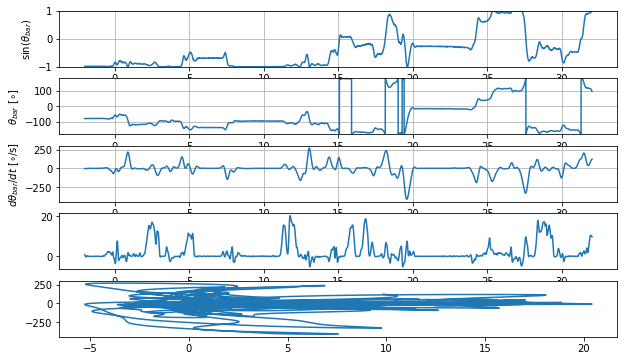

Trial 006: 0.00s (0.0%) in front
Trial 006: Fixation success: False
Trial 006: Maximum fixation duration: 0.00s


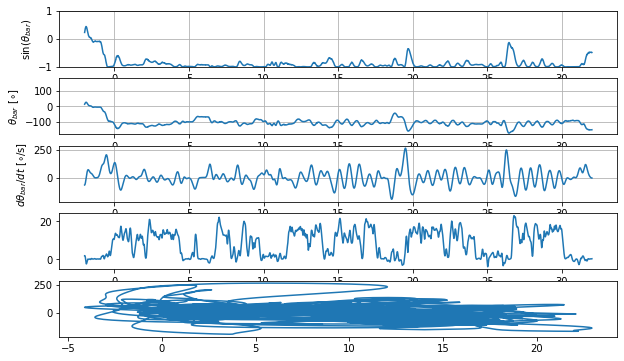

Trial 007: 0.46s (1.5%) in front
Trial 007: Fixation success: False
Trial 007: Maximum fixation duration: 0.46s


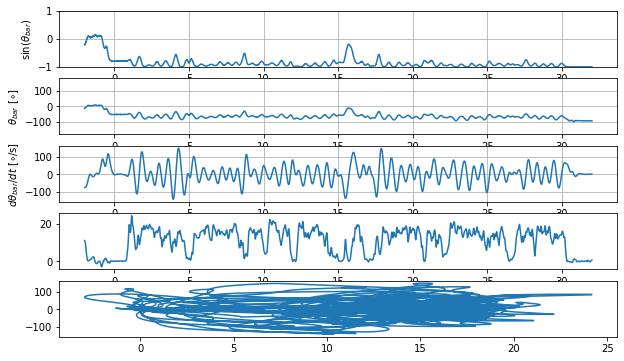

Trial 008: 0.00s (0.0%) in front
Trial 008: Fixation success: False
Trial 008: Maximum fixation duration: 0.00s


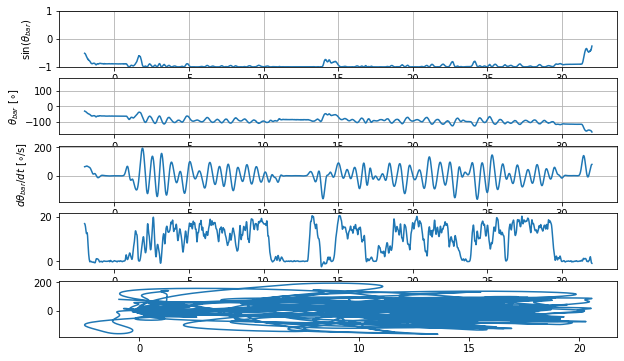

Trial 009: 0.44s (1.5%) in front
Trial 009: Fixation success: False
Trial 009: Maximum fixation duration: 0.44s


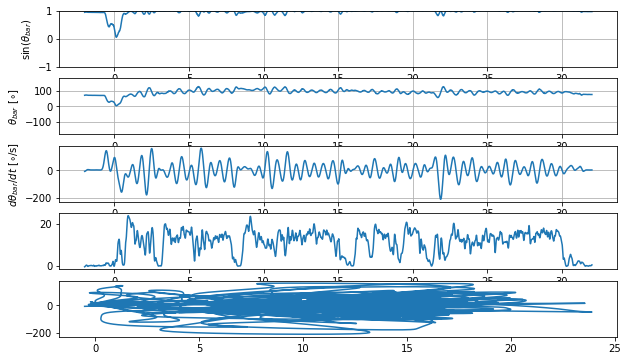

Trial 010: 1.73s (5.8%) in front
Trial 010: Fixation success: False
Trial 010: Maximum fixation duration: 0.41s


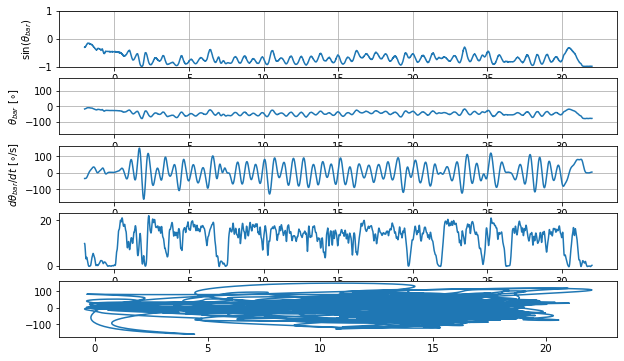

Trial 011: 0.00s (0.0%) in front
Trial 011: Fixation success: False
Trial 011: Maximum fixation duration: 0.00s


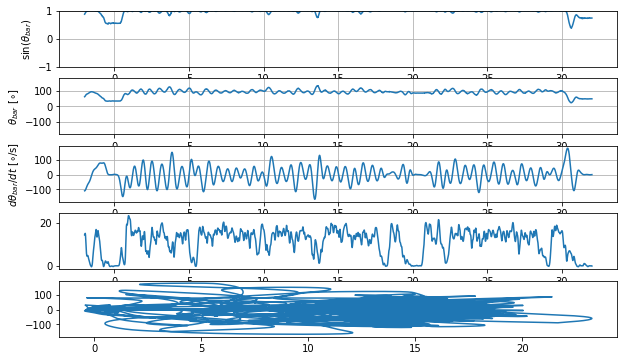

Trial 012: 9.06s (30.2%) in front
Trial 012: Fixation success: False
Trial 012: Maximum fixation duration: 1.85s


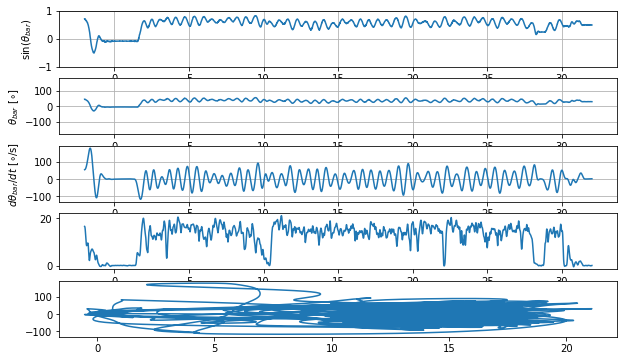

Trial 013: 0.00s (0.0%) in front
Trial 013: Fixation success: False
Trial 013: Maximum fixation duration: 0.00s


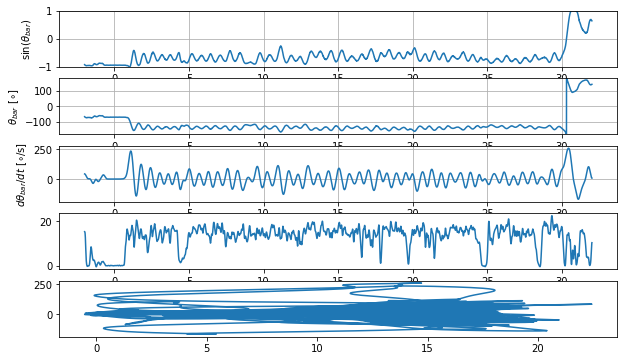

Trial 014: 0.89s (3.0%) in front
Trial 014: Fixation success: False
Trial 014: Maximum fixation duration: 0.53s


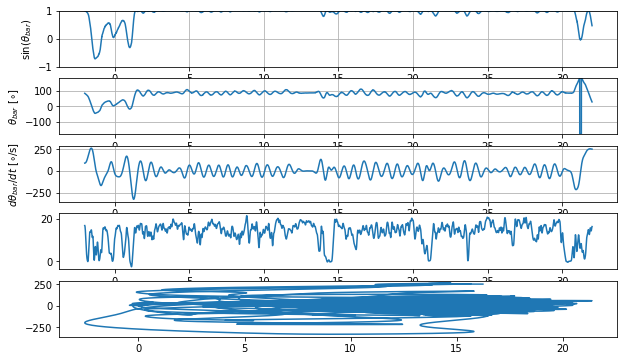

Trial 015: 0.00s (0.0%) in front
Trial 015: Fixation success: False
Trial 015: Maximum fixation duration: 0.00s


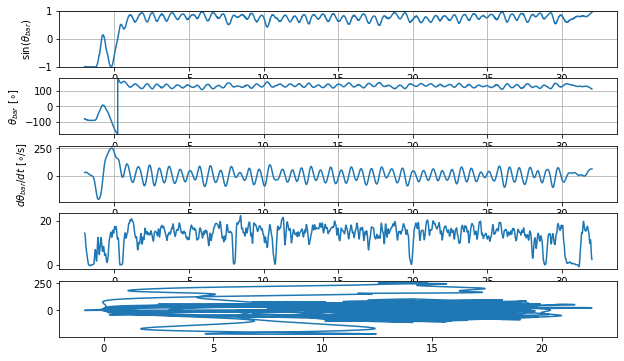

Trial 016: 0.00s (0.0%) in front
Trial 016: Fixation success: False
Trial 016: Maximum fixation duration: 0.00s


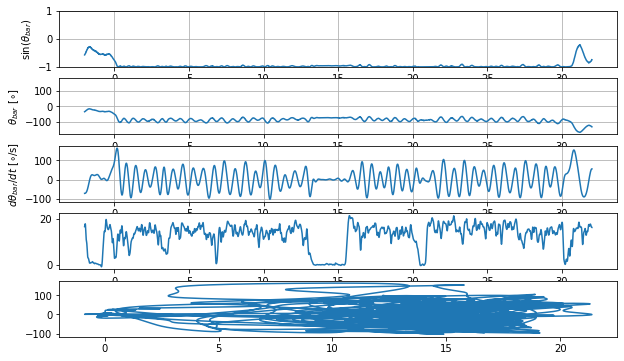

Trial 017: 1.20s (4.0%) in front
Trial 017: Fixation success: False
Trial 017: Maximum fixation duration: 1.20s


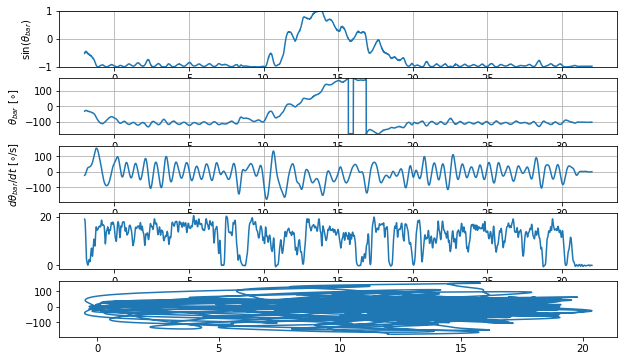

Trial 018: 1.43s (4.8%) in front
Trial 018: Fixation success: False
Trial 018: Maximum fixation duration: 0.68s


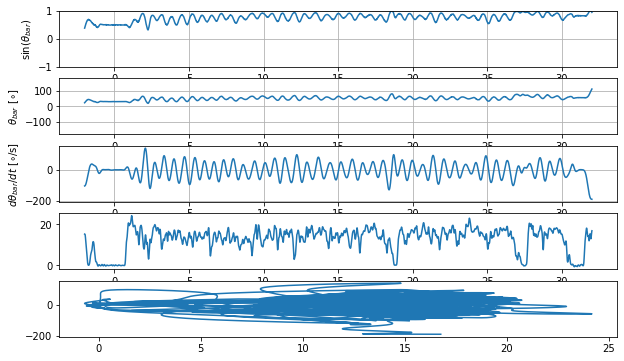

Trial 019: 0.00s (0.0%) in front
Trial 019: Fixation success: False
Trial 019: Maximum fixation duration: 0.00s


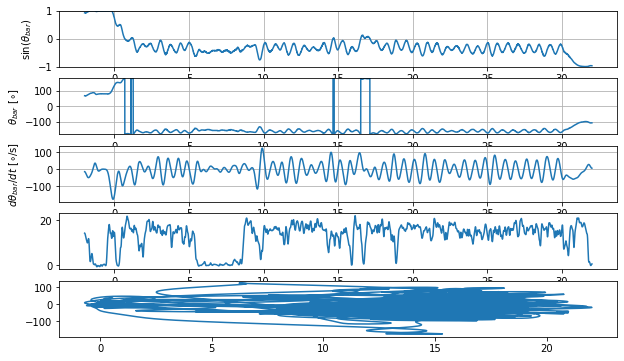

Trial 020: 0.00s (0.0%) in front
Trial 020: Fixation success: False
Trial 020: Maximum fixation duration: 0.00s


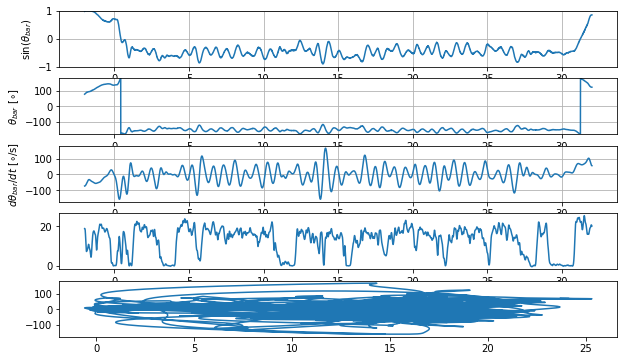

Trial 021: 9.55s (31.8%) in front
Trial 021: Fixation success: True
Trial 021: Maximum fixation duration: 5.22s


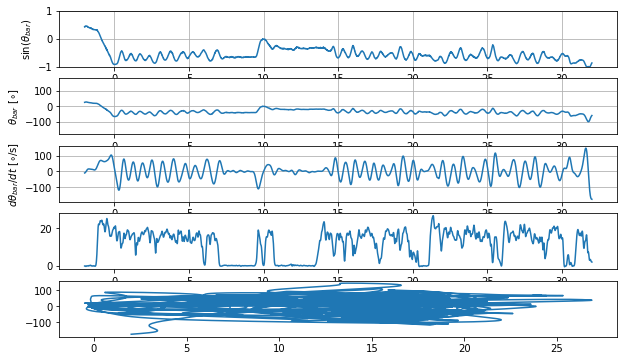

Trial 022: 12.79s (42.6%) in front
Trial 022: Fixation success: False
Trial 022: Maximum fixation duration: 1.03s


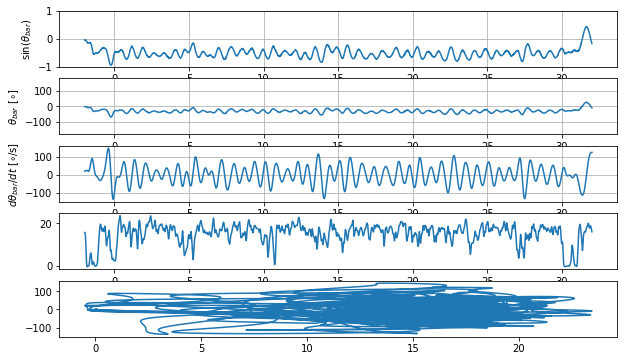

Trial 023: 0.00s (0.0%) in front
Trial 023: Fixation success: False
Trial 023: Maximum fixation duration: 0.00s


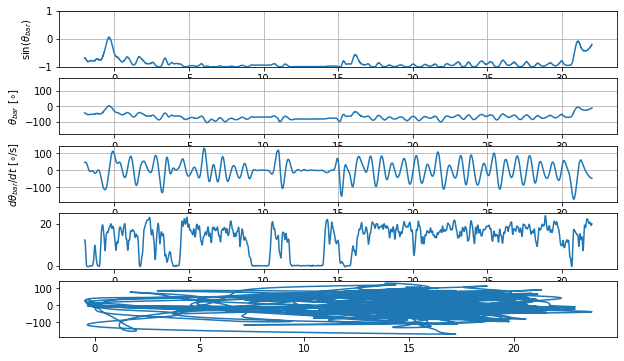

Trial 024: 0.17s (0.6%) in front
Trial 024: Fixation success: False
Trial 024: Maximum fixation duration: 0.17s


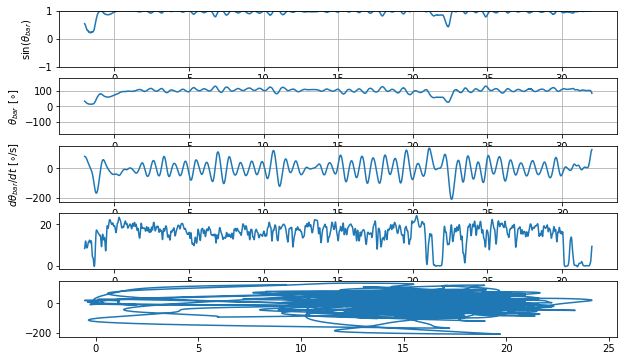

Trial 025: 7.67s (25.6%) in front
Trial 025: Fixation success: True
Trial 025: Maximum fixation duration: 4.29s


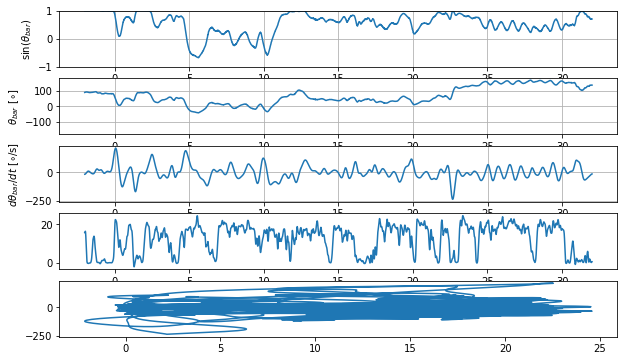

Trial 026: 0.00s (0.0%) in front
Trial 026: Fixation success: False
Trial 026: Maximum fixation duration: 0.00s


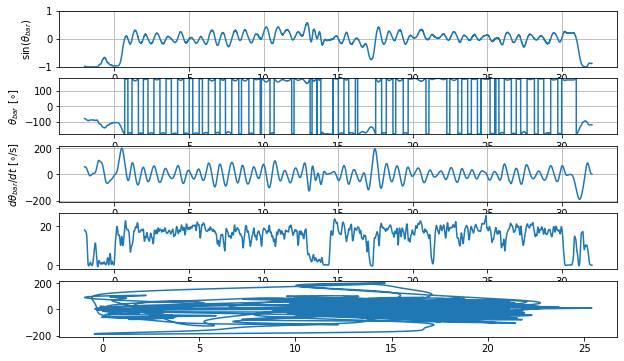

Trial 027: 0.00s (0.0%) in front
Trial 027: Fixation success: False
Trial 027: Maximum fixation duration: 0.00s


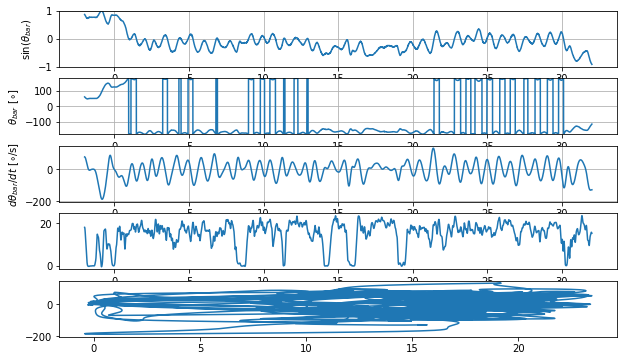

Trial 028: 18.77s (62.6%) in front
Trial 028: Fixation success: True
Trial 028: Maximum fixation duration: 2.87s


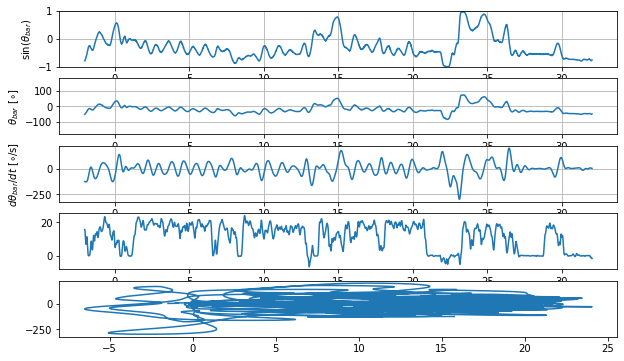

Trial 029: 0.00s (0.0%) in front
Trial 029: Fixation success: False
Trial 029: Maximum fixation duration: 0.00s


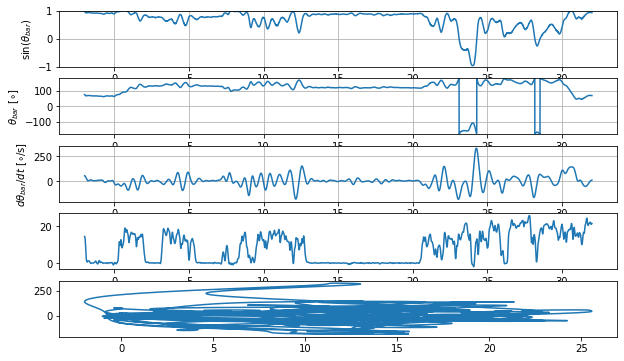

Trial 030: 0.00s (0.0%) in front
Trial 030: Fixation success: False
Trial 030: Maximum fixation duration: 0.00s


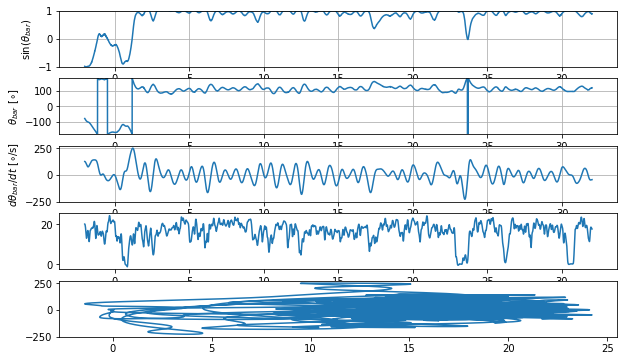

Trial 031: 0.62s (2.1%) in front
Trial 031: Fixation success: False
Trial 031: Maximum fixation duration: 0.62s


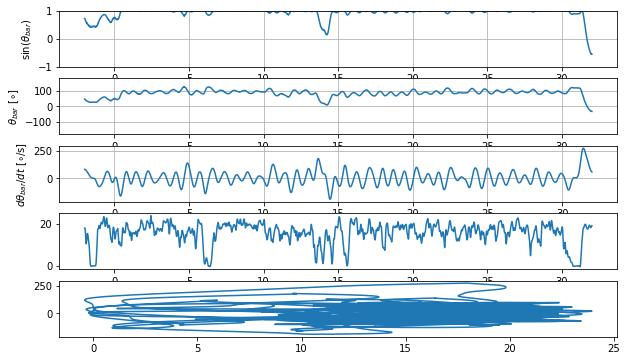

Trial 032: 0.00s (0.0%) in front
Trial 032: Fixation success: False
Trial 032: Maximum fixation duration: 0.00s


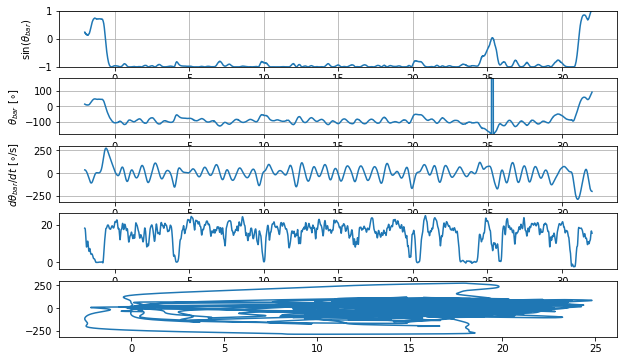

Trial 033: 0.00s (0.0%) in front
Trial 033: Fixation success: False
Trial 033: Maximum fixation duration: 0.00s


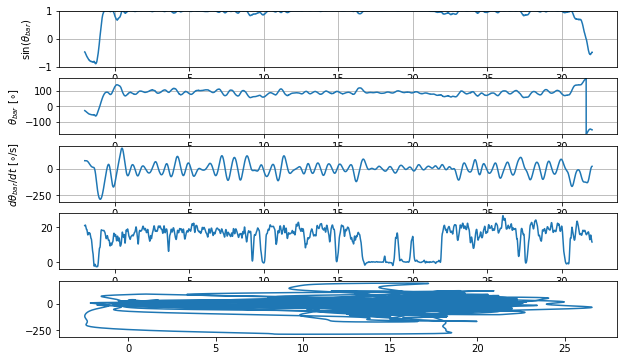

Trial 034: 0.35s (1.2%) in front
Trial 034: Fixation success: False
Trial 034: Maximum fixation duration: 0.35s


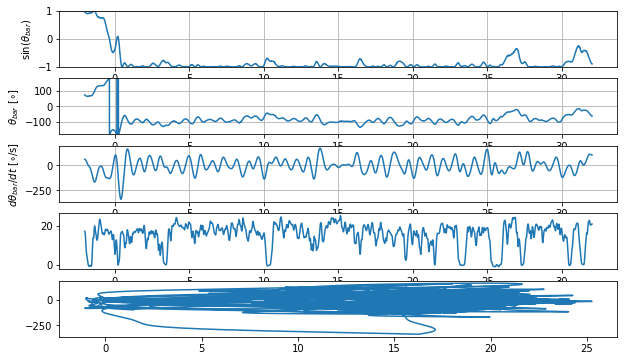

Trial 035: 0.43s (1.4%) in front
Trial 035: Fixation success: False
Trial 035: Maximum fixation duration: 0.43s


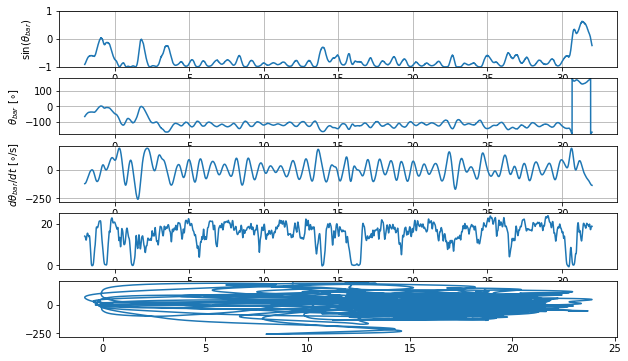

Trial 036: 26.82s (89.4%) in front
Trial 036: Fixation success: True
Trial 036: Maximum fixation duration: 12.11s


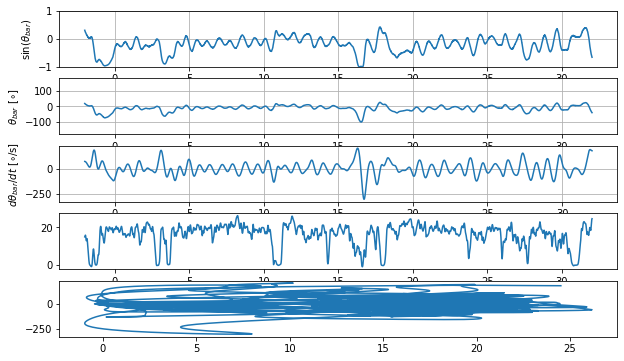

Trial 037: 15.94s (53.1%) in front
Trial 037: Fixation success: True
Trial 037: Maximum fixation duration: 2.41s


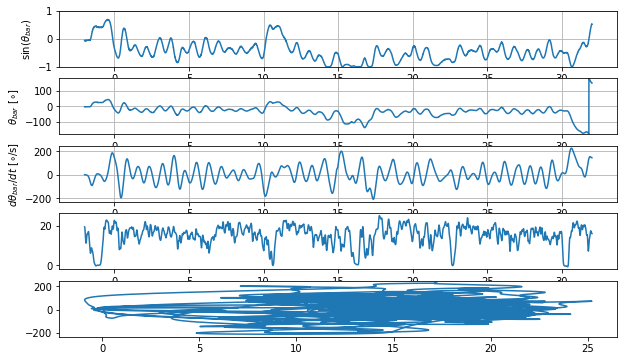

Trial 038: 7.68s (25.6%) in front
Trial 038: Fixation success: False
Trial 038: Maximum fixation duration: 0.99s


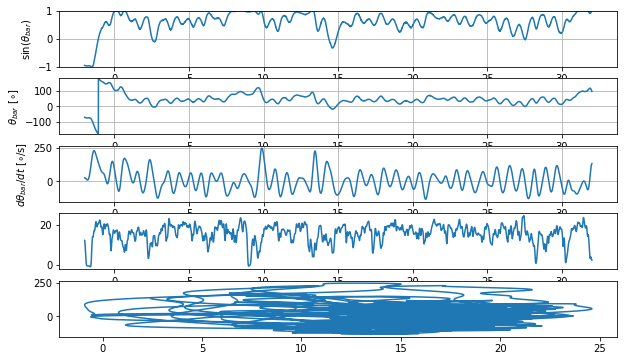

Trial 039: 0.00s (0.0%) in front
Trial 039: Fixation success: False
Trial 039: Maximum fixation duration: 0.00s


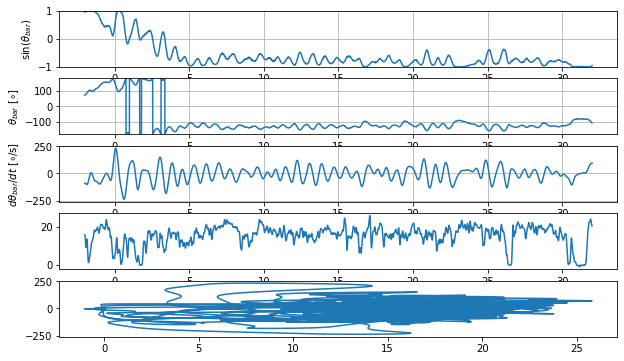

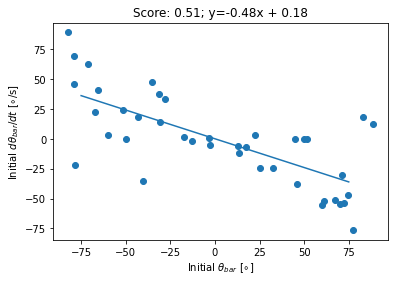

In [137]:

        ### 2. bar's position as a time of function ("theta")



    ## draw histogram of delta from center







hdf_path = "/Users/yandanwang/Desktop/data/fix_stationary/20220413_140128.h5"

acc_fixation_success_15, acc_fixation_durations_15,acc_max_fixation_duration_15,acc_mean_bar_position = analyze_fix_stationary(hdf_path, front_region=[-30,30])


In [68]:
acc_mean_bar_position

NameError: name 'acc_mean_bar_position' is not defined

Trial 000: 30.00s (100.0%) in front
Trial 000: Fixation success: True
Trial 000: Maximum fixation duration: 30.00s


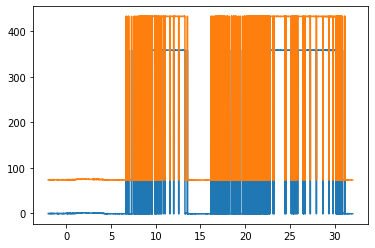

ValueError: Invalid location identifier (invalid location identifier)

In [189]:
acc_fixation_success_30, acc_fixation_durations_30,acc_max_fixation_duration_30 = analyze_fix_stationary(hdf_path, front_region=[-30,30])


In [181]:
value_acc_fixation_success_15 = []
for elem in acc_fixation_success_15:
    value_acc_fixation_success_15.append(int(elem))
#print(value_acc_fixation_success)
sum(value_acc_fixation_success_15)
#plt.plot(value_acc_fixation_success)

6

In [182]:
value_acc_fixation_success_30 = []
for elem in acc_fixation_success_30:
    value_acc_fixation_success_30.append(int(elem))
#print(value_acc_fixation_success)
sum(value_acc_fixation_success_30)
#plt.plot(value_acc_fixation_success)

14

In [163]:
value_acc_fixation_success = []
for elem in acc_fixation_success_30:
    value_acc_fixation_success.append(int(elem))
#print(value_acc_fixation_success)
sum(value_acc_fixation_success)
#plt.plot(value_acc_fixation_success)

22

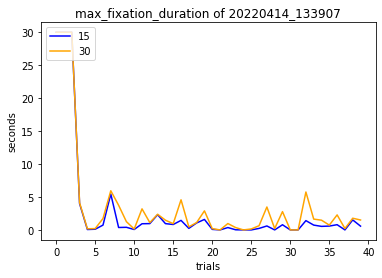

In [183]:
plt.plot(acc_max_fixation_duration_15,color = 'blue',label = '15')
plt.plot(acc_max_fixation_duration_30,color = 'orange',label = '30')
plt.title('max_fixation_duration of 20220414_133907')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.legend(loc = "upper left")

In [38]:
acc_fixation_durations

[array([0.24594244]),
 array([1.07230524, 0.10165585, 0.58370133, 0.1246104 , 0.22954547,
        0.43613638]),
 array([], dtype=float64),
 array([0.11149365, 0.60665661, 0.48860451, 0.1705197 , 0.70503336]),
 array([0.14100691, 1.76750526, 1.02311993, 0.22954614, 0.22626691,
        0.26561767, 0.21642922, 0.14100691]),
 array([0.29840998]),
 array([0.80013039, 0.00655845, 0.00655845, 0.22626638, 0.19675338,
        0.50827955, 0.08853902, 0.20987027, 0.1574027 , 0.11805203,
        0.36727297, 0.33448074, 0.44597432, 0.00655845]),
 array([0.76733995, 0.18691614, 0.12788999]),
 array([0.43941587]),
 array([1.74783097, 0.31480633, 0.10165621, 0.00327923, 0.00327923,
        0.02951309, 0.38039098, 0.0098377 , 0.0098377 , 0.00655847,
        0.71159347, 0.32136479, 0.17707856, 1.17068603, 0.23938398,
        0.49188489, 0.13772777, 0.58698263, 0.51811875]),
 array([0.06558442, 0.1574026 , 0.41974028]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([0.49188374, 1.41662517]

In [42]:
np.shape(acc_fixation_durations)

/Users/Shirley/opt/anaconda3/envs/clandinin/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(40,)

NameError: name 'fixation_success' is not defined